<a href="https://colab.research.google.com/github/erofale/encoderProject/blob/master/Code/encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Input, Dense, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
import keras.backend as K
from keras.layers import Lambda
from keras.regularizers import L1L2
import numpy as np
import random

In [94]:
def f(x,y):
  return x*y/10-3
mi=-1e13-3
ma=1e13-3
siz=ma-mi+1
def g(x):
  return (x-mi)/siz

In [ ]:
def f(x):
  return 2*x-1
mi=-2e7-1
ma=2e7
siz=ma-mi+1
def g(x):
  return (x-mi)/siz

In [96]:
TRAIN=60000
TEST=10000
siz_vec=3                        ###function size
x_train=np.ndarray((TRAIN,siz_vec))
x_test=np.ndarray((TEST,siz_vec))
for i in range(TRAIN):
  c1=random.randint(-10000000,10000000)
  c2=random.randint(-10000000,10000000)
  x_train[i]=(g(c1),g(c2),g(f(c1,c2)))
for i in range(TEST):
  c1=random.randint(-10000000,10000000)
  c2=random.randint(-10000000,10000000)
  x_test[i]=(g(c1),g(c2),g(f(c1,c2)))

3


In [102]:
# Сжимающий автоэнкодер
def create_dense_ae():
    encoding_dim = 1                                                            #размер внутреннего слоя

    # Энкодер
    input_img = Input(shape=(siz_vec))                                          #вход
    encoded = Dense(encoding_dim, activation='relu')(input_img)                 #слой
    
    # Декодер
    input_encoded = Input(shape=(encoding_dim,))                                #вход
    flat_decoded = Dense(siz_vec, activation='sigmoid')(input_encoded)         #слой

    # Модель
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, flat_decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

In [104]:
encoded_imgs = encoder.predict(x_test, batch_size=10)
decoded_imgs = decoder.predict(encoded_imgs, batch_size=10)

In [106]:
print(decoded_imgs[0])
print(x_test[0])

[0.5        0.49999997 0.37180462]
[0.49999971 0.5000002  0.38356538]


In [103]:
# Сборка и обучение обычного автоэнкодера
encoder, decoder, autoencoder = create_dense_ae()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0102
Epoch 2/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0079
Epoch 3/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 4/50
235/235 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 5/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 6/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 7/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 8/50
235/235 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 9/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 10/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0034

In [ ]:
# Глубокий автоэнкодер
def create_dense_ae():
    # Размерность кодированного представления
    encoding_dim = 1

    # Энкодер
    input_img = Input(shape=(2))
    flat_img = Flatten()(input_img)
    x = Dense(encoding_dim*2, activation='relu')(flat_img)
    x = Dense(encoding_dim*2, activation='relu')(x)
    encoded = Dense(encoding_dim, activation='linear')(x)
    
    # Декодер
    input_encoded = Input(shape=(encoding_dim,))
    x = Dense(encoding_dim*2, activation='relu')(input_encoded)
    x = Dense(encoding_dim*2, activation='relu')(x)
    flat_decoded = Dense(2, activation='sigmoid')(x)
    #decoded = Reshape((2))(flat_decoded)
    
    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, flat_decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

In [ ]:
# Сверточный автоэнкодер
def create_deep_conv_ae():
    input_img = Input(shape=(28, 28, 1))

    x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (7, 7), activation='relu', padding='same')(x)

    # На этом моменте представление  (7, 7, 1) т.е. 49-размерное

    input_encoded = Input(shape=(7, 7, 1))
    x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)

    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

In [ ]:
# Denoising модель (подавляющий шумы автоэнкодер)
batch_size = 16

def create_denoising_model(autoencoder):
    def add_noise(x):
        noise_factor = 0.5
        x = x + K.random_normal(x.get_shape(), 0.5, noise_factor)
        x = K.clip(x, 0., 1.)
        return x

    input_img  = Input(batch_shape=(batch_size, 28, 28, 1))
    noised_img = Lambda(add_noise)(input_img)

    noiser = Model(input_img, noised_img, name="noiser")
    denoiser_model = Model(input_img, autoencoder(noiser(input_img)), name="denoiser")
    return noiser, denoiser_model

In [ ]:
# Разреженный (Sparse) автоэнкодер
def create_sparse_ae():
    encoding_dim = 16
    lambda_l1 = 0.00001
    
    # Энкодер
    input_img = Input(shape=(28, 28, 1))
    flat_img = Flatten()(input_img)
    x = Dense(encoding_dim*3, activation='relu')(flat_img)
    x = Dense(encoding_dim*2, activation='relu')(x)
    encoded = Dense(encoding_dim, activation='linear', activity_regularizer=L1L2(lambda_l1))(x)
    
    # Декодер
    input_encoded = Input(shape=(encoding_dim,))
    x = Dense(encoding_dim*2, activation='relu')(input_encoded)
    x = Dense(encoding_dim*3, activation='relu')(x)
    flat_decoded = Dense(28*28, activation='sigmoid')(x)
    decoded = Reshape((28, 28, 1))(flat_decoded)
    
    # Модели
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Отрисовка картинок 
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

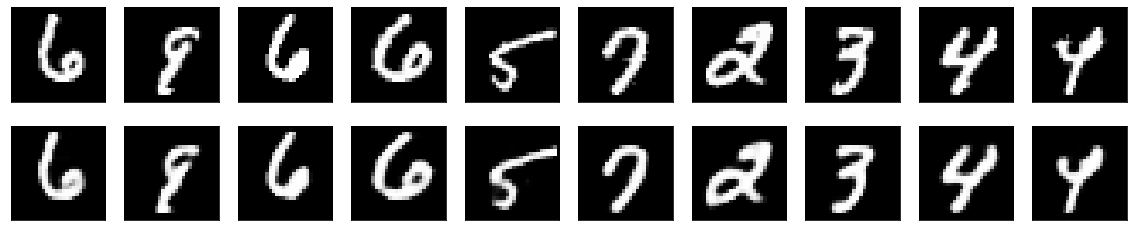

In [ ]:
# Отрисовка оригинальных и декодированных картинок
r = random.randint(0, 10000 - n)
imgs = x_test[r:r+n]
encoded_imgs = d_encoder.predict(imgs, batch_size=n)

decoded_imgs = d_decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

In [ ]:
# Сборка и обучение свёрточного автоэнкодера
c_encoder, c_decoder, c_autoencoder = create_deep_conv_ae()
c_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

c_autoencoder.fit(x_train, x_train,
                epochs=64,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/64
235/235 [==============================] - 1452s 6s/step - loss: 0.1698 - val_loss: 0.0984
Epoch 2/64
 17/235 [=>............................] - ETA: 22:02 - loss: 0.1003

KeyboardInterrupt: ignored

In [ ]:
# Отрисовка оригинальных и декодированных картинок
r = random.randint(0, 10000 - n)
imgs = x_test[r:r+n]
encoded_imgs = с_encoder.predict(imgs, batch_size=n)

decoded_imgs = с_decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

In [ ]:
# Сборка и обучение модели с шумами
noiser, denoiser_model = create_denoising_model(autoencoder)
denoiser_model.compile(optimizer='adam', loss='binary_crossentropy')

denoiser_model.fit(x_train, x_train,
                   epochs=200,
                   batch_size=batch_size,
                   shuffle=True,
                   validation_data=(x_test, x_test))

Epoch 1/200
3750/3750 [==============================] - 14s 4ms/step - loss: 0.1678 - val_loss: 0.1371
Epoch 2/200
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1360 - val_loss: 0.1314
Epoch 3/200
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1324 - val_loss: 0.1307
Epoch 4/200
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1310 - val_loss: 0.1286
Epoch 5/200
3750/3750 [==============================] - 10s 3ms/step - loss: 0.1303 - val_loss: 0.1281
Epoch 6/200
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1297 - val_loss: 0.1285
Epoch 7/200
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1293 - val_loss: 0.1271
Epoch 8/200
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1290 - val_loss: 0.1266
Epoch 9/200
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1288 - val_loss: 0.1271
Epoch 10/200
3750/3750 [==============================] - 11s 3m

In [ ]:
# Отрисовка оригинальных, зашумлённых и декодированных картинок
r = random.randint(0, 10000 - n)
imgs = x_test[r:r+n]
noised_imgs = noiser.predict(imgs, batch_size=batch_size)
encoded_imgs = encoder.predict(noised_imgs[r:r+n],  batch_size=n)
decoded_imgs = decoder.predict(encoded_imgs[r:r+n], batch_size=n)

plot_digits(imgs[r:r+n], noised_imgs, decoded_imgs)

In [ ]:
# Сборка и обучение разреженного автоэнкодера
s_encoder, s_decoder, s_autoencoder = create_sparse_ae()
s_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

s_autoencoder.fit(x_train, x_train,
                epochs=400,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
# Отрисовка оригинальных и декодированных картинок
r = random.randint(0, 10000 - n)
imgs = x_test[r:r+n]
encoded_imgs = s_encoder.predict(imgs, batch_size=n)

decoded_imgs = s_decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)